In [2]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../../../data/base_models/gpt4/temperature7_eval.csv')
df.head()

,id,mcq_json,rubric,question,option_a,option_b,option_c,option_d,correct_option,content_gpt,originality,readability,starts_with_negation,is_question,relevance,ambiguity,gpt_answer,disclosure,difficulty
0,OIC-360-01-A,{'question': 'What is the primary characterist...,Definition,What is the primary characteristic of a pneumo...,Gas effusion in the pleural cavity,Fluid accumulation in the lungs,Solid mass formation in the chest,Excessive blood flow in the pleural cavity,a,**Item Parent:** Pneumothorax \n**Title:** De...,1.000000,12.605000,False,True,0.719928,0.737606,a,False,5
1,OIC-360-08-A,{'question': 'What is a key consideration when...,NaN,What is a key consideration when evaluating th...,The size of the pneumothorax directly correlat...,Only respiratory signs are important for asses...,Haemodynamic signs like shock can indicate sev...,A partial pneumothorax is always well tolerated.,c,**Item Parent:** Pneumothorax \n**Title:** Kn...,1.000000,13.673333,False,True,0.787061,0.710479,c,False,2
2,OIC-360-03-A,{'question': 'What is essential for confirming...,Positive diagnosis,What is essential for confirming a diagnosis o...,Physical examination alone,Laboratory blood tests,Thoracic imaging,Patient history,c,**Item Parent:** Pneumothorax \n**Title:** Kn...,1.000000,16.462500,False,True,0.777840,0.557716,c,False,4
3,OIC-360-11-B,{'question': 'What is a recommended measure to...,NaN,What is a recommended measure to prevent the r...,Increase physical activity,Smoking cessation,High altitude exposure,Increased salt intake,b,**Item Parent:** Pneumothorax \n**Title:** Kn...,0.333333,13.372727,False,True,0.826552,0.496496,b,True,5
4,OIC-360-10-B,{'question': 'What is an indication for pleura...,Management,What is an indication for pleural drainage in ...,Primary pneumothorax with successful exsufflation,Secondary pneumothorax with a quick pleural br...,Primary pneumothorax with failed exsufflation,Secondary pneumothorax without any pleural breach,c,**Item Parent:** Pneumothorax \n**Title:** Kn...,1.000000,12.690000,False,True,0.863942,0.818946,c,False,2


In [4]:
# normalize correct_option
df['correct_option'] = df['correct_option'].replace({'option_b': 'b', 'option_c': 'c', 'option_d': 'd'}) 

# Question mark

In [5]:
# We want to maximize 'True'
question_count = {
    'True': df['is_question'].sum(),
    'False': len(df) - df['is_question'].sum()
}

question_count

{'True': np.int64(4693), 'False': np.int64(0)}

# Negation

In [6]:
# We want to minimze 'True'
starts_with_negation_count = {
    'True': df['starts_with_negation'].sum(),
    'False': len(df) - df['starts_with_negation'].sum()
}

starts_with_negation_count

{'True': np.int64(0), 'False': np.int64(4693)}

# Originality

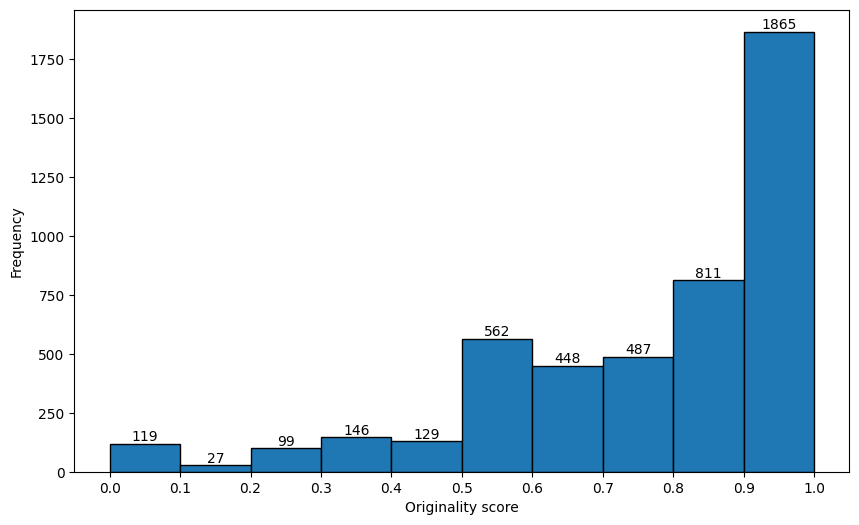

In [7]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['originality'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Originality score')
plt.ylabel('Frequency')
plt.show()

# Readability

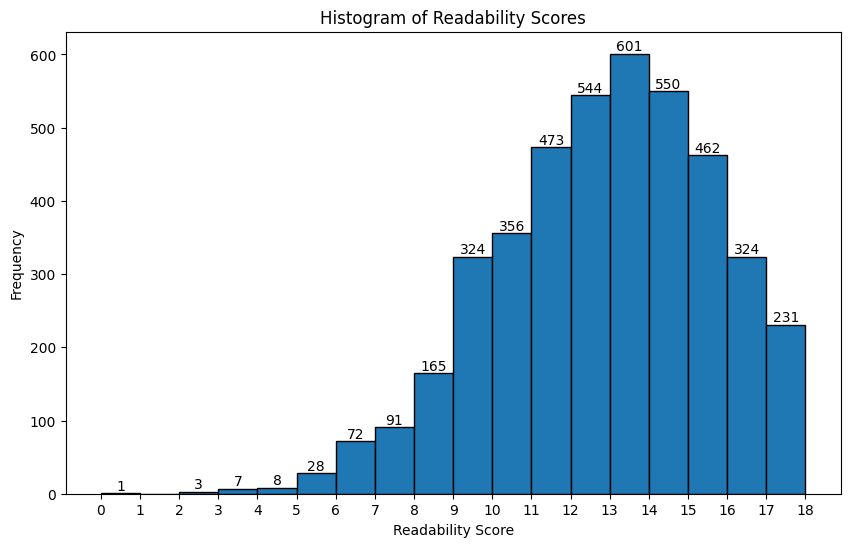

In [8]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['readability'], bins=range(0, 19, 1), edgecolor='black')

# Set x-axis ticks from 0 to 18
plt.xticks(range(0, 19))

# Add frequency labels on top of each bar where frequency > 0
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.show()

# Answer Length

In [9]:
option_cols = ['option_a', 'option_b', 'option_c', 'option_d']

# Create new columns with word counts for each option column
for col in option_cols:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))

AttributeError: module 'numpy' has no attribute 'matrix'

In [ ]:
def get_correct_option_rank(row):
    # Get the original word counts for each option
    counts = [
        row['option_a_word_count'],
        row['option_b_word_count'],
        row['option_c_word_count'],
        row['option_d_word_count']
    ]

    # Map correct_option letter to its index (0 for A, 1 for B, etc.)
    letter_to_index = {'A': 0, 'a':0, 'B': 1, 'b':1, 'C': 2, 'c':2, 'D': 3, 'd':3}
    correct_idx = letter_to_index[row['correct_option']]

    # Determine the word count of the correct option
    correct_count = counts[correct_idx]

    # Create an effective counts list:
    # For non-correct options, if their word count equals the correct option's word count,
    # treat them as if they had one extra word.
    effective_counts = []
    for i, count in enumerate(counts):
        if i != correct_idx and count == correct_count:
            effective_counts.append(count + 1)
        else:
            effective_counts.append(count)

    # Sort the option indices by descending effective count.
    ordering = sorted(range(4), key=lambda i: effective_counts[i], reverse=True)

    # Compute the rank as the 1-indexed position of the correct option in the ordering.
    rank = ordering.index(correct_idx) + 1
    return rank

In [ ]:
def get_rank_distribution(df):
  rank_distribution = df['correct_option_rank'].value_counts().sort_index()
  rank_distribution = round(rank_distribution / len(df), 2) * 100

  plt.figure(figsize=(8, 6))
  plt.bar(rank_distribution.index, rank_distribution.values, color='skyblue', edgecolor='black')
  plt.xlabel('N (1 = Longest, 4 = Shortest)')
  plt.ylabel('Frequency, %')
  plt.title('How often the correct option is N`th longest')
  plt.xticks([1, 2, 3, 4])
  plt.show()

In [ ]:
df['correct_option_rank'] = df.apply(get_correct_option_rank, axis=1)
get_rank_distribution(df)

# Disclosure

In [ ]:
disclosure_count = {
    'True': df['disclosure'].sum(),
    'False': len(df) - df['disclosure'].sum()
}

disclosure_count

# Relevance to the input material

In [ ]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['relevance'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

# Ambiguity (cosine similarity)

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['ambiguity'], bins=10, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Ambiguity")

# Difficulty (judge LLM)

In [ ]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['difficulty'], bins=np.arange(1, 7)-0.5, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Syntactic Ambiguity")
plt.xticks(range(1, 6))

# Show the plot
plt.show()

# Answerability
can judge model answer the generated question with context provided?

In [ ]:
df['gpt_answer'].unique()

In [ ]:
df['correct_option'].unique()

In [ ]:
answerability_count = {
    'True': (df['correct_option'] == df['gpt_answer']).sum(),
    'False': len(df) - (df['correct_option'] == df['gpt_answer']).sum()
}

answerability_count